In [53]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from scipy import stats


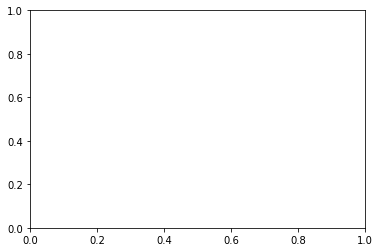

In [2]:
def plot_xi(data, ax = plt.gca(),**kwargs):
    x = data[:,0]
    y = data[:,0]**2*data[:,1]
    ax.plot(x, y, **kwargs)
    ax.set_xlabel(r'$s$ [$h^{-1}$Mpc]', fontsize=12)
    ax.set_ylabel(r'$\xi_0(s)$', fontsize=12)
    return x, y
def plot_delta_xi(data, ax = plt.gca(),**kwargs):
    x = data[:,0]
    y = data[:,0]**2*data[:,1]
    delta_y = data[:,0]**2*data[:,2]
    ax.fill_between(x, y-delta_y, y+delta_y, **kwargs)

# SNR

In [3]:
snr_avg_2pcf_data = np.loadtxt(
    '../../results/nosyst_v7/tpcf_void_mock_R-15.5-50_avg/TwoPCF_mockavg_nosyst_v7_void_R-15.5-50_cbz.ascii'
)
s_bao = 102.5
s_1_dl = 82.5
s_2_dl = 87.5
s_1_dr = 117.5
s_2_dr = 122.5
s_values = [s_bao, s_1_dl, s_2_dl, s_1_dr, s_2_dr]

[20 16 17 23 24]


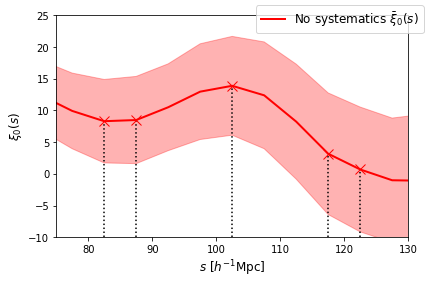

In [4]:
fig, ax = plt.subplots(1, 1)
snr_x, snr_y = plot_xi(snr_avg_2pcf_data,
                       ax=ax,
                       label=r'No systematics $\bar{\xi}_0(s)$',
                       c='r', lw=2)
plot_delta_xi(snr_avg_2pcf_data, ax=ax, alpha=0.3, color='r')
ax.set_xlim(75, 130)
ax.set_ylim(-10, 25)
s_ids = np.array([np.argwhere(snr_x == s) for s in s_values]).reshape(-1)
print(s_ids)
ax.vlines(s_values,
          ymin=-10*np.ones_like(s_ids),
          ymax=snr_y[s_ids],
          ls=':',
          color='k')
[
    ax.plot(snr_x[list(s_ids)],
            snr_y[list(s_ids)],
            marker='x',
            markersize=10,
            lw=0,
            color='r')
]
fig.legend(fontsize=12)
fig.tight_layout()
fig.savefig('snr_points.png', dpi=100)

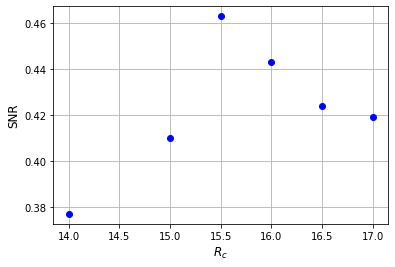

In [5]:
r_bin_min = [14, 15, 15.5, 16, 16.5, 17]
snr_values = [0.377, 0.410, 0.463, 0.443, 0.424, 0.419]
plt.plot(r_bin_min, snr_values, 'ob')
plt.ylabel('SNR', fontsize=12)
plt.xlabel('$R_c$', fontsize=12)
plt.grid()
plt.gcf()
plt.savefig('snr.png', dpi=100)

# Statistical ruler

In [6]:
seed = 42
np.random.seed(seed)
s = 1
sigma_narrow = 0.05
sigma_wide = 1
n_centers =100
n_points = 50
distances_narrow = np.random.normal(s, sigma_narrow, n_points)
distances_wide = np.random.normal(s, sigma_wide, n_points)
x_pos = 10*np.random.random(n_centers)
y_pos = 10*np.random.random(n_centers)
def put_point(x0, y0, s):
    theta = 2*np.pi*np.random.random()
    return x0 + s* np.cos(theta), y0 + s*np.sin(theta)
chain_narrow = []
chain_wide = []
for x0, y0 in zip(x_pos, y_pos):
    for rn, rw in zip(distances_narrow, distances_wide):
        chain_narrow.append(put_point(x0, y0, rn))
        chain_wide.append(put_point(x0, y0, rw))
chain_narrow=np.array(chain_narrow)
chain_wide=np.array(chain_wide)

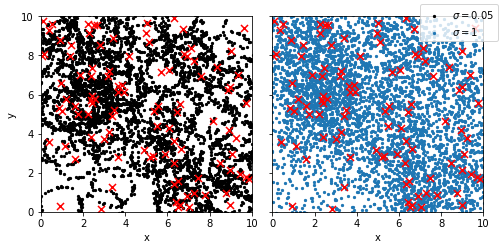

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (7, 3.5), sharey=True)
ax[0].scatter(chain_narrow[:,0], chain_narrow[:,1], s=5, label='$\sigma=0.05$', color ='k')
ax[1].scatter(chain_wide[:,0], chain_wide[:,1], s=5, label='$\sigma=1$')
[a.scatter(x_pos, y_pos, color = 'r', s=50, marker='x') for a in ax]
[a.set_xlim(0,10) for a in ax]
[a.set_ylim(0,10) for a in ax]
[a.set_xlabel('x', fontsize=10) for a in ax]
ax[0].set_ylabel('y')
fig.legend(fontsize=10)
fig.tight_layout()
fig.savefig('statruler.png', dpi=100)

# Priors


In [8]:
def nbar(theta, flat_min, flat_max, sigma):
    if theta < flat_min:
        return np.exp(-(theta-flat_min)**2/(2 * sigma**2))
    elif theta > flat_max:
        return np.exp(-(theta-flat_max)**2/(2 * sigma**2))
    else:
        return 1
vec_nbar = np.vectorize(nbar)
def n (theta, mu, sigma):
    return np.exp(-(theta-mu)**2/(2 * sigma**2))
def flat(theta, min_, max_):
    if theta > min_ and theta < max_:
        return 1.
    else:
        return 0.
vec_flat = np.vectorize(flat)

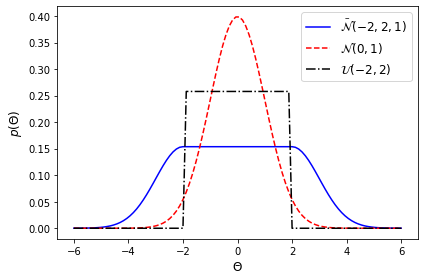

In [9]:
x = np.linspace(-6, 6, 100)
flat_gauss = vec_nbar(x, -2, 2, 1)
flat_gauss/=np.trapz(flat_gauss, x)
gauss = n(x, 0, 1)
gauss/=np.trapz(gauss, x)
flat_ = vec_flat(x, -2, 2)
flat_/=np.trapz(flat_, x)
plt.plot(x, flat_gauss, label = r'$\mathcal{\bar{N}}(-2, 2, 1)$', ls = '-', c = 'b')
plt.plot(x, gauss, label = r'$\mathcal{N}(0, 1)$', ls = '--', c = 'r')
plt.plot(x, flat_, label = r'$\mathcal{U}(-2, 2)$', ls = '-.', c = 'k')
plt.ylabel(r'$p(\Theta)$', fontsize = 12)
plt.xlabel(r'$\Theta$', fontsize = 12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.gcf()
plt.savefig('priors.png', dpi=100)


# Void radius distribution

In [55]:
nosyst_data = pd.read_csv('example_nosyst_void_cat.ascii',
                          names=['ra', 'dec', 'z', 'r'],
                          delim_whitespace=True)
allsyst_data = pd.read_csv('example_allsyst_void_cat.ascii',
                           names=['ra', 'dec', 'z', 'r'],
                           delim_whitespace=True)

In [61]:
no_kde = stats.gaussian_kde(nosyst_data['r'].data)
all_kde = stats.gaussian_kde(allsyst_data['r'].data)
no_used_voids = no_kde.integrate_box_1d(15.5, 50)
all_used_voids = all_kde.integrate_box_1d(15.5, 50)
print(no_used_voids, all_used_voids)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.data is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  


0.33811963184910204 0.4536377830749533


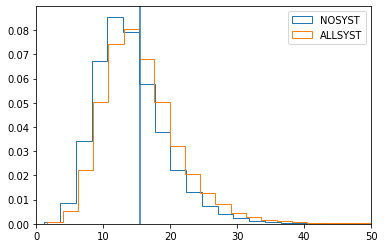

In [22]:
no_counts, no_bin_edges,_ = plt.hist(nosyst_data[:,3], bins = 100, density=True, histtype='step', label = 'NOSYST')
all_counts, all_bin_edges,_ = plt.hist(allsyst_data[:,3], bins = 100, density = True, histtype='step', label='ALLSYST')
plt.axvline(15.5)
plt.xlim(0, 50)
plt.legend()

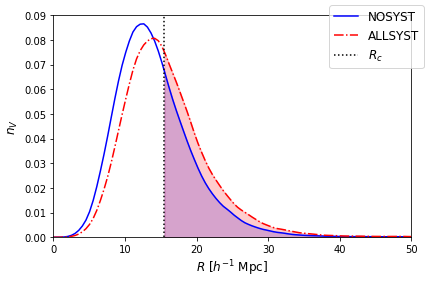

In [63]:
valid_r = np.linspace(15.5, 50, 100)
fig, ax = plt.subplots()
ax.set_xlim(0, 50)
ax.set_ylim(0, 0.09)
#nosyst_data.plot(y = 'r', kind = 'hist', ax = ax, bins = 100, density=True, color='b')
nosyst_data.plot(y='r',
                 kind='kde',
                 ax=ax,
                 color='b',
                 ls='-',
                 label='NOSYST',
                 ind=np.linspace(0, 50, 100),
                 legend=False)
#allsyst_data.plot(y = 'r', kind = 'hist', ax = ax, bins = 100, density=True, color = 'r')
allsyst_data.plot(y='r',
                  kind='kde',
                  ax=ax,
                  color='r',
                  ls='-.',
                  label='ALLSYST',
                  ind=np.linspace(0, 50, 100),
                  legend=False)
ax.fill_between(valid_r, no_kde(valid_r), color = 'b', alpha = 0.2)
ax.fill_between(valid_r, all_kde(valid_r), color = 'r', alpha = 0.2)
ax.axvline(15.5, label=r'$R_c$', ls=':', c = 'k')
ax.set_ylabel(r'$n_V$', fontsize=12)
ax.set_xlabel(r'$R$ [$h^{-1}$ Mpc]', fontsize=12)
fig.legend(fontsize=12)
fig.tight_layout()
fig.savefig('radiusdist.png', dpi=100)